# Holidays and Special Dates

Calendar variables and special dates are one of the most common types of exogenous variables used in forecasting applications. They provide additional context on the current state of the time series, especially for window-based models such as TimeGPT-1. These variables often include adding information on each observation's month, week, day, or hour. For example, in high-frequency hourly data, providing the current month of the year provides more context than the limited history available in the input window to improve the forecasts.

In this tutorial we will show how to add calendar variables automatically to a dataset using the `date_features` function.

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/2_holidays')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/2_holidays.ipynb)

In [ ]:
#| hide
from fastcore.test import test_eq, test_fail, test_warns
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'my_token_provided_by_nixtla'
)

In [ ]:
#| hide
timegpt = TimeGPT()

Given the predominance usage of calendar variables, we included an automatic creation of common calendar variables to the forecast method as a pre-processing step. To automatically add calendar variables, use the `date_features` argument.

In [ ]:
pltr_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/pltr.csv')

In [ ]:
fcst_pltr_calendar_df = timegpt.forecast(
    df=pltr_df.tail(2 * 14), h=14, freq='B',
    time_col='date', target_col='Close',
    date_features=['month','weekday']
)
fcst_pltr_calendar_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: month_8, month_9, month_10, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,date,TimeGPT
0,2023-09-25,14.688427
1,2023-09-26,14.742798
2,2023-09-27,14.781240
3,2023-09-28,14.824156
4,2023-09-29,14.795214


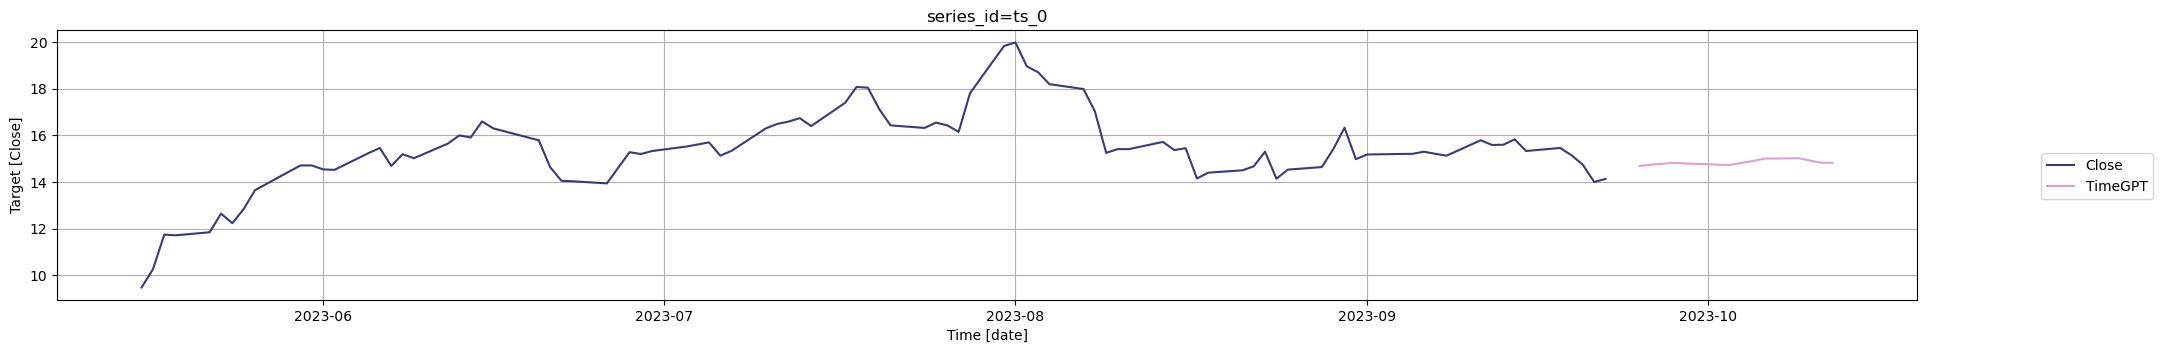

In [ ]:
timegpt.plot(
    pltr_df, 
    fcst_pltr_calendar_df, 
    id_col='series_id',
    time_col='date',
    target_col='Close',
    max_insample_length=90,
)

We can also plot the importance of each of the date features:

<Axes: ylabel='features'>

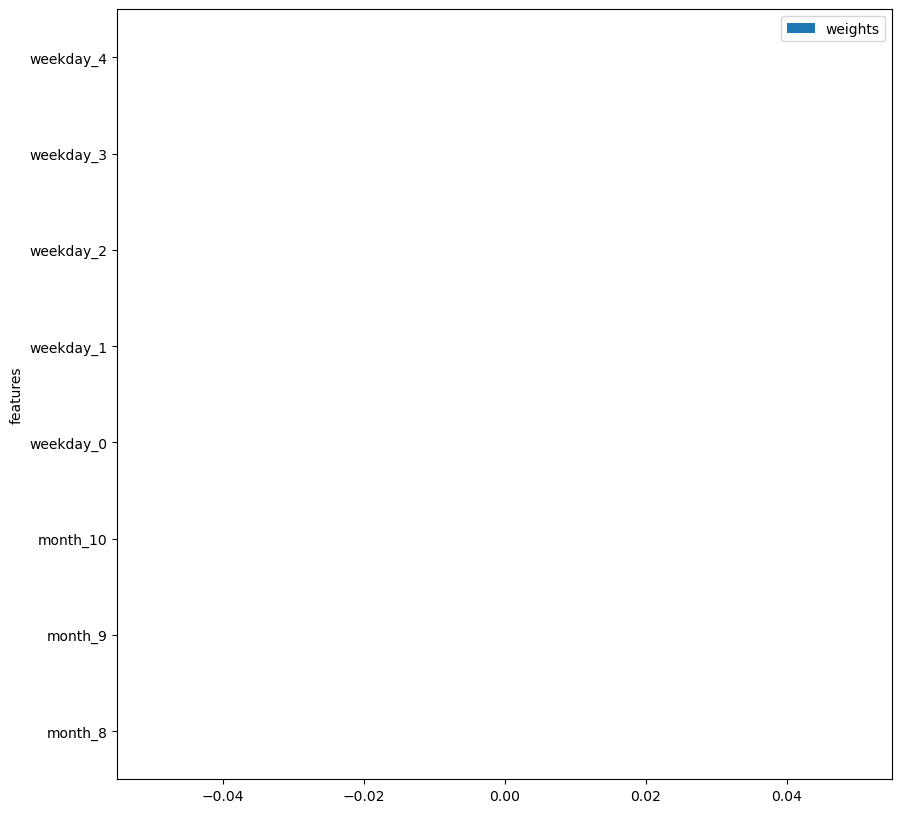

In [ ]:
timegpt.weights_x.plot.barh(x='features', y='weights', figsize=(10, 10))

You can also add country holidays using the `CountryHolidays` class.

In [ ]:
from nixtlats.date_features import CountryHolidays

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: US_Martin Luther King Jr. Day, US_Washington's Birthday, US_Columbus Day, US_New Year's Day, US_Memorial Day, US_Independence Day, US_Independence Day (Observed), US_Labor Day, US_Veterans Day, US_Thanksgiving, US_Christmas Day, US_New Year's Day (Observed), US_Juneteenth National Independence Day, US_Juneteenth National Independence Day (Observed), US_Christmas Day (Observed), US_Veterans Day (Observed)
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


<Axes: ylabel='features'>

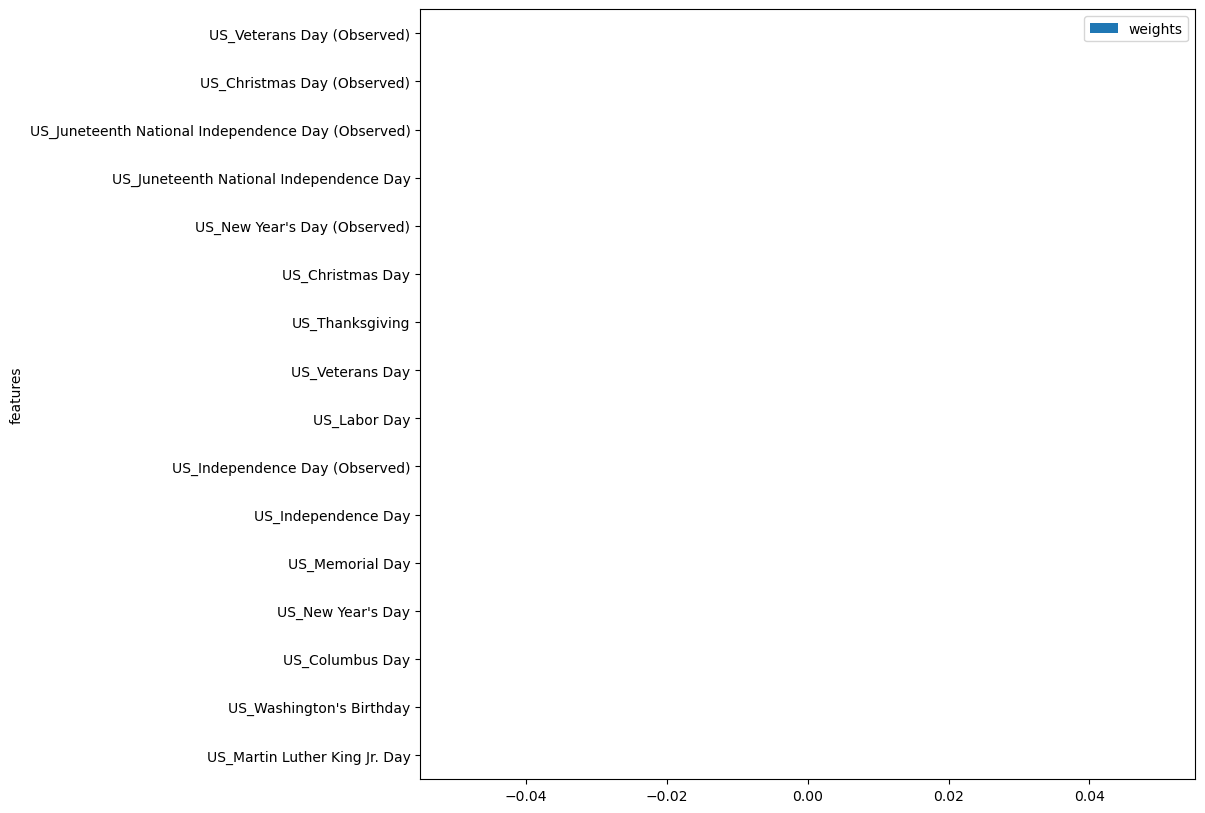

In [ ]:
fcst_pltr_calendar_df = timegpt.forecast(
    df=pltr_df, h=14, freq='B',
    time_col='date', target_col='Close',
    date_features=[CountryHolidays(['US'])]
)
timegpt.weights_x.plot.barh(x='features', y='weights', figsize=(10, 10))


Here's a breakdown of how the `date_features` parameter works:

- **`date_features` (bool or list of str or callable)**: This parameter specifies which date attributes to consider.
    - If set to `True`, the model will automatically add the most common date features related to the frequency of the given dataframe (`df`). For a daily frequency, this could include features like day of the week, month, and year.
    - If provided a list of strings, it will consider those specific date attributes. For example, `date_features=['weekday', 'month']` will only add the day of the week and month as features.
    - If provided a callable, it should be a function that takes dates as input and returns the desired feature. This gives flexibility in computing custom date features.

- **`date_features_to_one_hot` (bool or list of str)**: After determining the date features, one might want to one-hot encode them, especially if they are categorical in nature (like weekdays). One-hot encoding transforms these categorical features into a binary matrix, making them more suitable for many machine learning algorithms.
    - If `date_features=True`, then by default, all computed date features will be one-hot encoded.
    - If provided a list of strings, only those specific date features will be one-hot encoded.

By leveraging the `date_features` and `date_features_to_one_hot` parameters, one can efficiently incorporate the temporal effects of date attributes into their forecasting model, potentially enhancing its accuracy and interpretability.